# Self-Driving Car Engineer Nanodegree

## Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import pandas as pd

training_file = "../data/train.p"
validation_file=  "../data/valid.p"
testing_file =  "../data/test.p"

# Open classes 
signnames_file = "./signnames.csv"
classes = pd.read_csv(signnames_file,sep=',', header=0)

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Basic Summary of the Data Set

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = classes.shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline

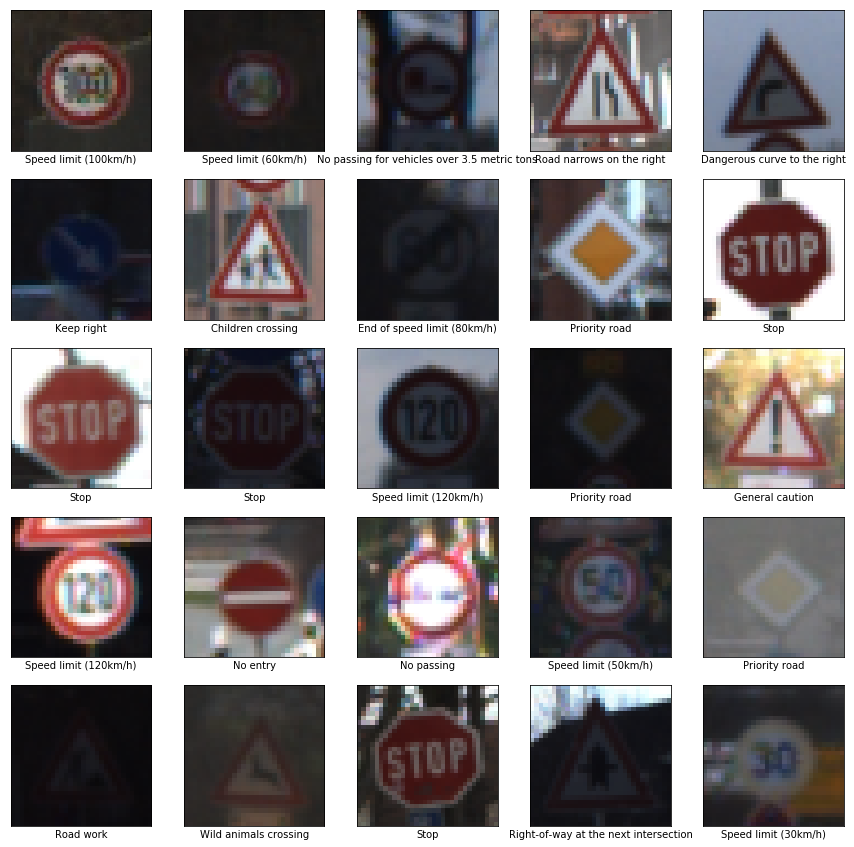

In [4]:
import random

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    i_ran = random.randint(0, len(X_train)-1)
    plt.imshow(X_train[i_ran])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[classes['ClassId'] == y_train[i_ran]]['SignName'].max())
plt.show()

Text(0.5,0,'Traffic sign ID')

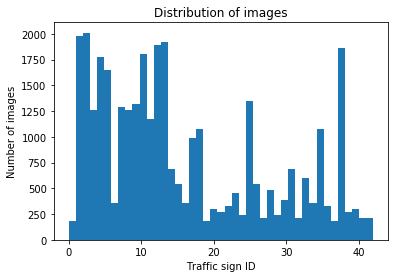

In [5]:
plt.hist(y_train, n_classes)
plt.title("Distribution of images")
plt.ylabel("Number of images")
plt.xlabel("Traffic sign ID")

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [6]:
# Set this to true if you don't want to rebuild the augmented dataset
load_preprocessed_data_from_save = True

In [7]:
import numpy as np
import cv2

In [8]:
# Convert images to grayscale
def grayscale(img):
    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.reshape(img, (32, 32, 1))
    return img

if not load_preprocessed_data_from_save:
    # Grayscale
    X_train = np.array([grayscale(img) for img in X_train])
    X_valid = np.array([grayscale(img) for img in X_valid])
    X_test = np.array([grayscale(img) for img in X_test])

In [9]:
# Generate augmented dataset
import keras
from keras.preprocessing.image import ImageDataGenerator

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)


Using TensorFlow backend.


In [10]:
if not load_preprocessed_data_from_save:
    X_augmented = np.empty((0,32,32,1))
    y_augmented = np.empty(0,dtype='uint8')

    batches = 0
    for X, y in datagen.flow(X_train, y_train, batch_size=32, seed = 3421):
        X_augmented = np.append(X_augmented, X, axis=0)
        y_augmented = np.append(y_augmented, y, axis=0)
        batches += 1
        if batches >= len(X_train) / 32:
            break


In [11]:
if not load_preprocessed_data_from_save:
    # Visualize augmented dataset
    plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        i_ran = random.randint(0, len(X_augmented)-1)
        plt.imshow(X_augmented[i_ran].squeeze(), cmap='gray')

    plt.show()

In [12]:
if not load_preprocessed_data_from_save:
    # Combine the original dataset with the augmented dataset
    X_train = np.concatenate((X_train, X_augmented), axis=0)
    y_train = np.concatenate((y_train, y_augmented), axis=0)

In [13]:
# Shuffle the data so the augmented images are mixed
from sklearn.utils import shuffle
if not load_preprocessed_data_from_save:
    X_train, y_train = shuffle(X_train, y_train)

In [14]:
if not load_preprocessed_data_from_save:
    # Normalized so that the data has mean zero and equal variance
    X_train = X_train.astype('float64')
    X_valid = X_valid.astype('float64')
    X_test = X_test.astype('float64')

    #training_mean = np.mean(X_train)
    #training_std = np.std(X_train)
    
    
    # (pixel - 128)/ 128
    X_train -= 128
    X_train /= 128

    X_valid -= 128
    X_valid /= 128

    X_test -= 128
    X_test /= 128

In [15]:
if load_preprocessed_data_from_save:
    print("Loaded data from save")
    X_train = pickle.load( open( "../augmenteddata/training.p", "rb" ) )
    X_valid = pickle.load( open( "../augmenteddata/validation.p", "rb" ) )
    X_test = pickle.load( open( "../augmenteddata/testing.p", "rb" ) )
    y_train = pickle.load( open( "../augmenteddata/y_training.p", "rb" ) )
    
else:
    print("Saved data to file")
    pickle.dump( X_train, open( "../augmenteddata/training.p", "wb+" ) )
    pickle.dump( X_valid, open( "../augmenteddata/validation.p", "wb+" ) )
    pickle.dump( X_test, open( "../augmenteddata/testing.p", "wb+" ) )
    pickle.dump( y_train, open( "../augmenteddata/y_training.p", "wb+" ) )

Loaded data from save


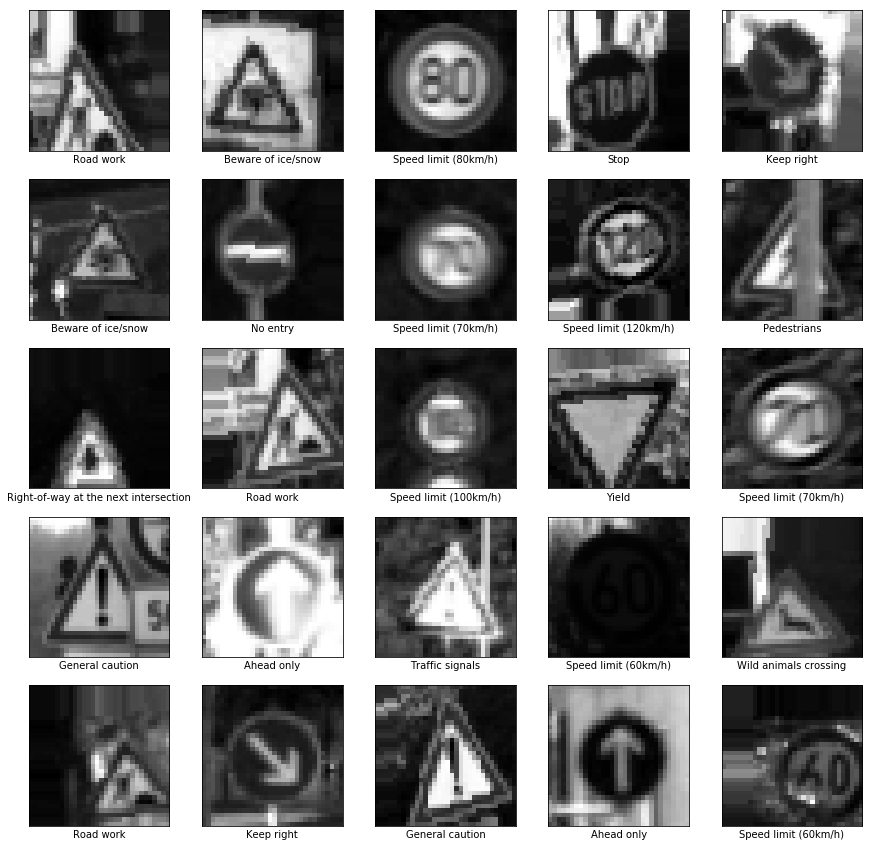

In [16]:
import random

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    i_ran = random.randint(0, len(X_train)-1)
    plt.imshow(X_train[i_ran].squeeze(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[classes['ClassId'] == y_train[i_ran]]['SignName'].max())
plt.show()

### Model Architecture

In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten


def CNN(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    
    ############ Layer 1
    
    # Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    ############ Layer 2
    
    # Convolutional. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    ############ Layer 3
    
    # Convolutional. Input = 5x5x16. Output = 1x1x400.
    conv3_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3 = tf.nn.conv2d(conv2, conv3_w, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation
    conv3 = tf.nn.relu(conv3)
   
    
    ############ Layer 4
    
    combine_two_layers = tf.concat([flatten(conv3), flatten(conv2)], 1)
    combine_two_layers = tf.nn.dropout(combine_two_layers, keep_prob)
    
    # Fully Connected. Input = 800. Output = 100.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 100), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(100))
    fc1   = tf.matmul(combine_two_layers, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    
    ############ Layer 5
    
    # Fully Connected. Input = 100. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [18]:
import tensorflow as tf

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

In [20]:
rate = 0.0005

logits = CNN(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
EPOCHS = 20
BATCH_SIZE = 32
acc_val = []
acc_train = []

from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_train, y_train)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy   = {:.3f}".format(training_accuracy))
        acc_val.append(validation_accuracy)
        acc_train.append(training_accuracy)
        print()
        
    saver.save(sess, './savedmodel')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.671
Training Accuracy   = 0.541

EPOCH 2 ...
Validation Accuracy = 0.822
Training Accuracy   = 0.687

EPOCH 3 ...
Validation Accuracy = 0.862
Training Accuracy   = 0.757

EPOCH 4 ...
Validation Accuracy = 0.880
Training Accuracy   = 0.787

EPOCH 5 ...
Validation Accuracy = 0.902
Training Accuracy   = 0.819

EPOCH 6 ...
Validation Accuracy = 0.913
Training Accuracy   = 0.837

EPOCH 7 ...
Validation Accuracy = 0.923
Training Accuracy   = 0.856

EPOCH 8 ...
Validation Accuracy = 0.922
Training Accuracy   = 0.866

EPOCH 9 ...
Validation Accuracy = 0.929
Training Accuracy   = 0.881

EPOCH 10 ...
Validation Accuracy = 0.938
Training Accuracy   = 0.889

EPOCH 11 ...
Validation Accuracy = 0.941
Training Accuracy   = 0.900

EPOCH 12 ...
Validation Accuracy = 0.943
Training Accuracy   = 0.899

EPOCH 13 ...
Validation Accuracy = 0.941
Training Accuracy   = 0.906

EPOCH 14 ...
Validation Accuracy = 0.932
Training Accuracy   = 0.917

EPOCH 15 ...
Val

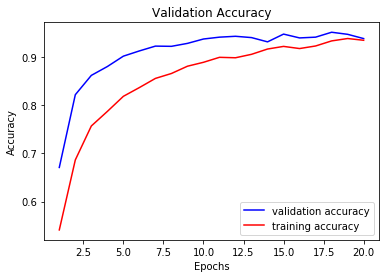

In [23]:
# Visulize validation accuracy
epochs = range(1,EPOCHS+1)
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.plot(epochs, acc_train, 'r', label='training accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
import tensorflow as tf
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=1)
correct_predictions = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./savedmodel.meta')
    saver.restore(sess, "./savedmodel")
    

    for i, img in enumerate(X_test):
        my_top_k = sess.run(top_k, feed_dict={x: [img], keep_prob: 1.0 })
        correct_predictions.append(my_top_k.indices[0][0] == y_test[i])

accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Accuracy on the test image dataset: {100*accuracy}%")    

INFO:tensorflow:Restoring parameters from ./savedmodel
Accuracy on the test image dataset: 93.76880443388757%


---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [25]:
import glob
import cv2
import numpy as np
traffic_images_from_internet = np.array([cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('../TrafficSignsFromInternet/*')])

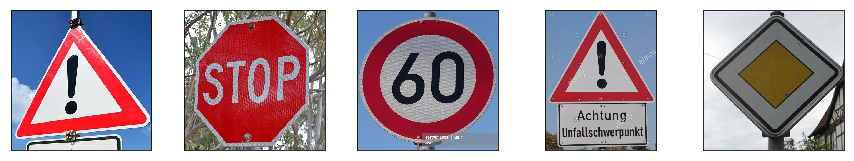

In [26]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(traffic_images_from_internet[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [27]:
traffic_images_from_internet_pro = []
for i in range(len(traffic_images_from_internet)):
    resized = cv2.resize(traffic_images_from_internet[i], (32, 32))
    gray = grayscale(resized)
    traffic_images_from_internet_pro.append(gray)

    
traffic_images_from_internet_pro = np.array(traffic_images_from_internet_pro, dtype = float)
traffic_images_from_internet_pro -= 128
traffic_images_from_internet_pro /= 128

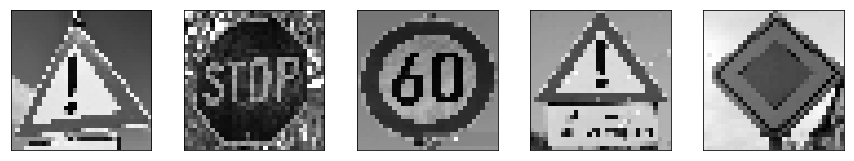

In [28]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(traffic_images_from_internet_pro[i].squeeze(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./savedmodel


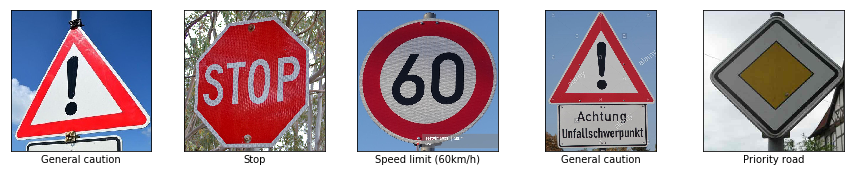

In [29]:
import tensorflow as tf
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=1)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./savedmodel.meta')
    saver.restore(sess, "./savedmodel")
    
    plt.figure(figsize=(15,15))
    for i, img in enumerate(traffic_images_from_internet_pro):
        my_top_k = sess.run(top_k, feed_dict={x: [img], keep_prob: 1.0 })
        # Print image and prediction
        plt.subplot(5,5,i+1)
        plt.imshow(traffic_images_from_internet[i])
        
        plt.xlabel(classes[classes['ClassId'] == my_top_k.indices[0][0]]['SignName'].max())
        plt.xticks([])
        plt.yticks([])
    plt.show()


### Analyze Performance

In [30]:
print("There are only 5 images, and we can see they are 100% accurate! :)")

There are only 5 images, and we can see they are 100% accurate! :)


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./savedmodel


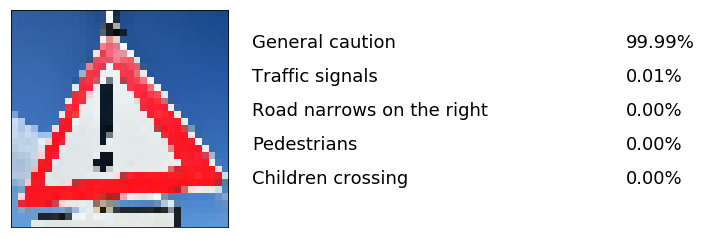

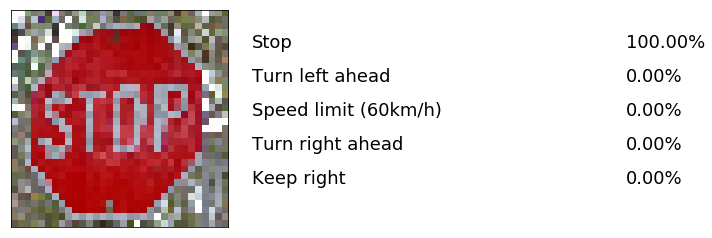

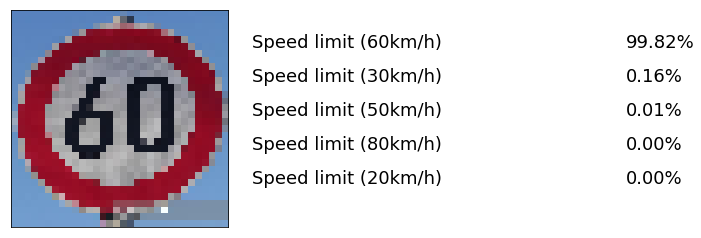

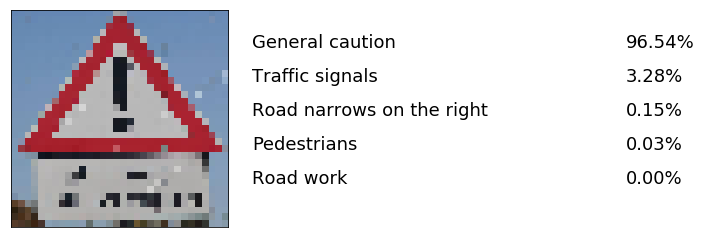

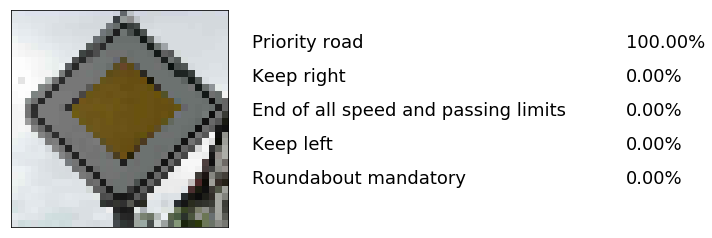

In [31]:
import tensorflow as tf
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./savedmodel.meta')
    saver.restore(sess, "./savedmodel")
    
    for i, img in enumerate(traffic_images_from_internet_pro):
        my_top_k = sess.run(top_k, feed_dict={x: [img], keep_prob: 1.0 })
        plt.imshow(cv2.resize(traffic_images_from_internet[i], (32,32)))
        
        for index, k in enumerate(my_top_k.indices[0]): 
            prob = f"{(my_top_k.values[0][index] * 100):.2f}%"
            sign_name =  classes[classes['ClassId'] == k]['SignName'].max()
            plt.text(35, index*5+5, sign_name, fontsize=18)
            plt.text(90, index*5+5, prob, fontsize=18)
            plt.xticks([])
            plt.yticks([])
            
        plt.show()